<a href="https://colab.research.google.com/github/zilver666/229352-StatisticalLearning-Lab/blob/main/Lab04_decision_tree_bagging_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #4

#### Load data at: https://donlapark.pages.dev/229352/heart_disease.csv

* Decision tree ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html))
* Random hyperparameter search using cross-validation ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html))

In [1]:
import pandas as pd
import graphviz

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# import data
data = pd.read_csv("https://donlapark.pages.dev/229352/heart_disease.csv", na_values="?")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [2]:

# split into X and y
y = data["label"]
X = data.drop("label", axis=1)

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# impute missing values
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Create a decision tree
clf = DecisionTreeClassifier()

![5CV](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [3]:
params = {'max_depth': [3, 6, 9, 12]}

gridcv = GridSearchCV(clf, params, scoring='accuracy', cv=5)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 6, 9, 12]}, scoring='accuracy')

In [4]:
gridcv.best_estimator_

DecisionTreeClassifier(max_depth=9)

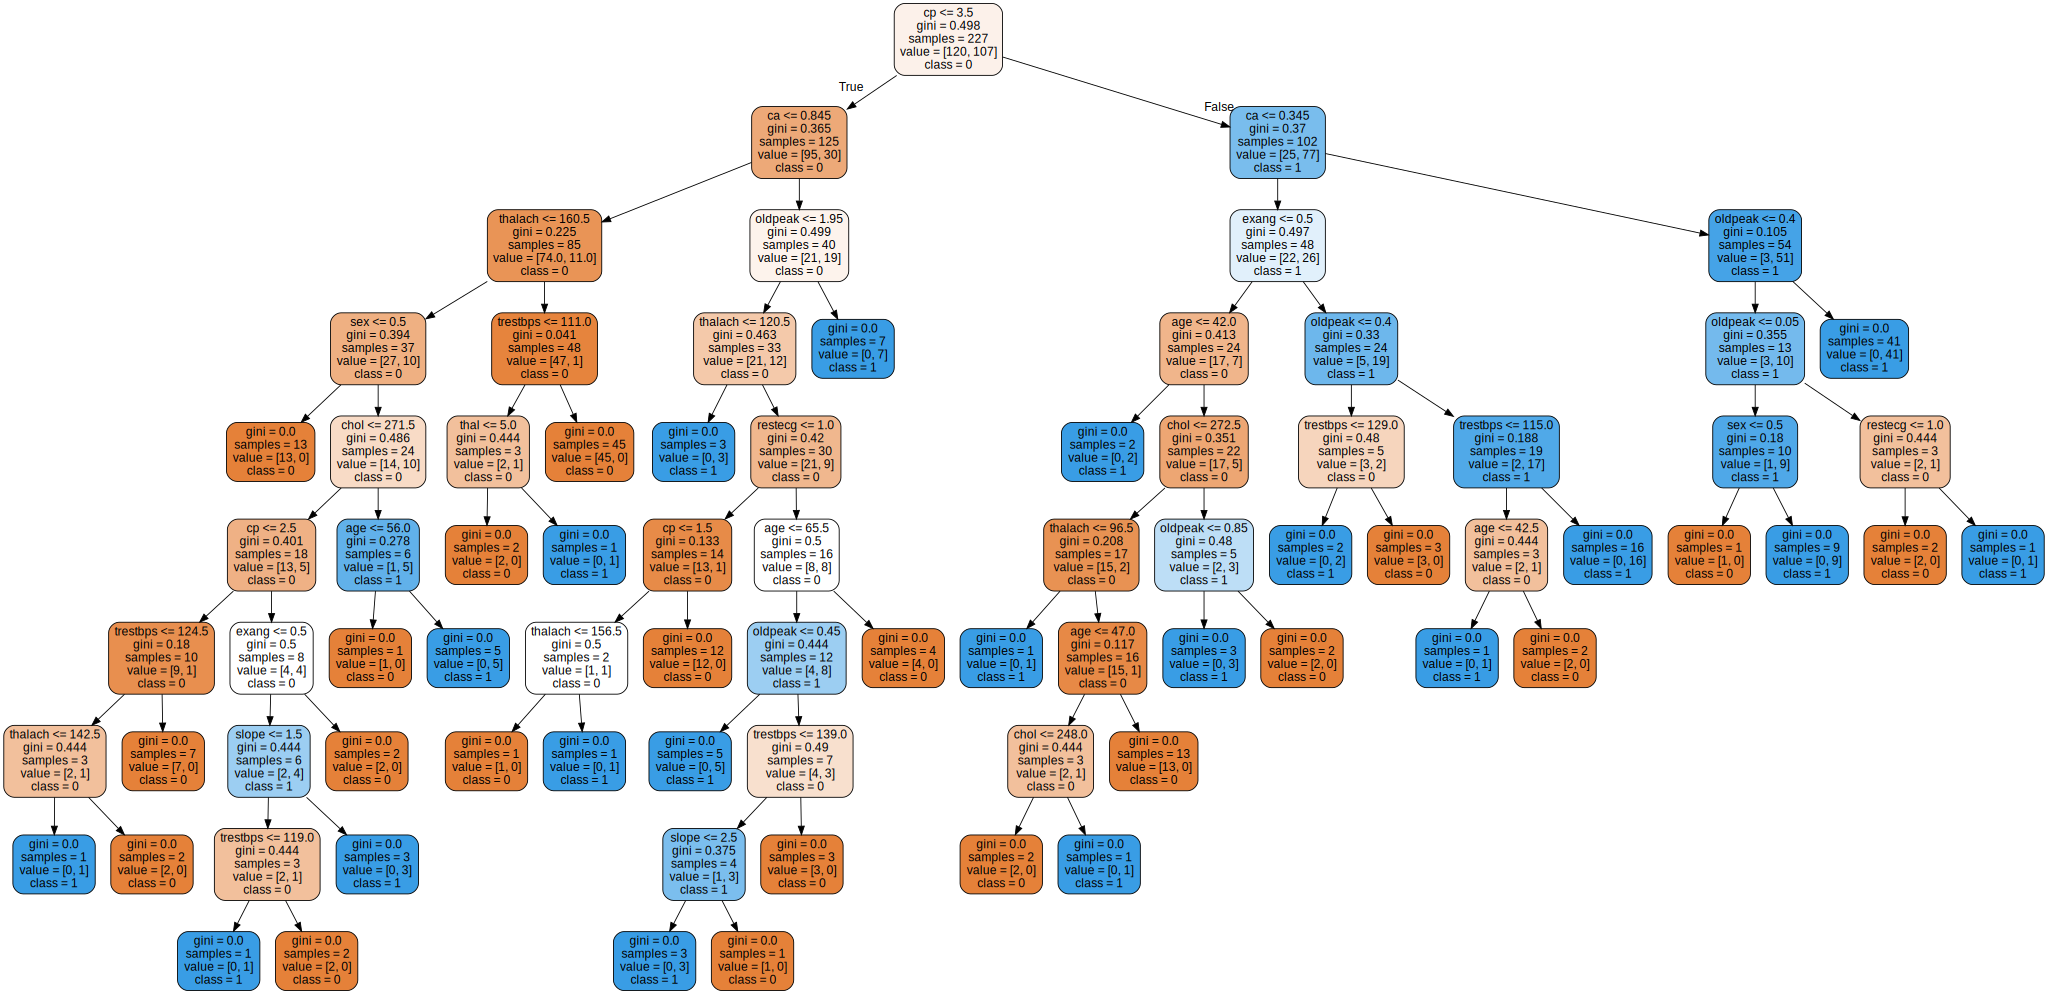

In [5]:
plot_data = export_graphviz(gridcv.best_estimator_,
                            out_file=None,
                            filled=True,
                            rounded=True,
                            feature_names=data.columns[:-1],
                            class_names=['0', '1'])

graph = graphviz.Source(plot_data)
graph

## Bagged decision trees
* Bagging classifier ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html))

In [6]:
bag_clf = BaggingClassifier(clf, n_estimators=100, random_state=42)
bag_clf.fit(X_train, y_train)

print(f"Bagging Test Score: {bag_clf.score(X_test, y_test):.4f}")

Bagging Test Score: 0.8684


## Random forest classifier
* Random forest ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

In [7]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

print(f"Random Forest Test Score: {rf_clf.score(X_test, y_test):.4f}")

Random Forest Test Score: 0.8947


#### Exercise
1. Study the hyperparameters of three models: [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Bagged Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. For each model, use pipeline+grid search cross-validation across multiple hyperparameters to find the best model.
* Decision tree: choose at least 3 hyperparameters
* Bagged decision trees: choose at least 3 hyperparameters
* Random forest: choose at least 3 hyperparameters
3. For each model, compute the `f1_macro` and `accuracy` score on the test set.
* What is your best model?
* Plot the best tree model
* What hyperparameters did you choose? (explain in words, not in `sklearn's` parameter name)
* What are the best values of your hyperparameters?

--- Decision Tree ---
Best Params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}
Accuracy: 0.8158, F1 Macro: 0.8093

--- Bagging ---
Best Params: {'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 100}
Accuracy: 0.8553, F1 Macro: 0.8522

--- Random Forest ---
Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8947, F1 Macro: 0.8910

Best Model is: RandomForestClassifier(max_depth=10, random_state=42)


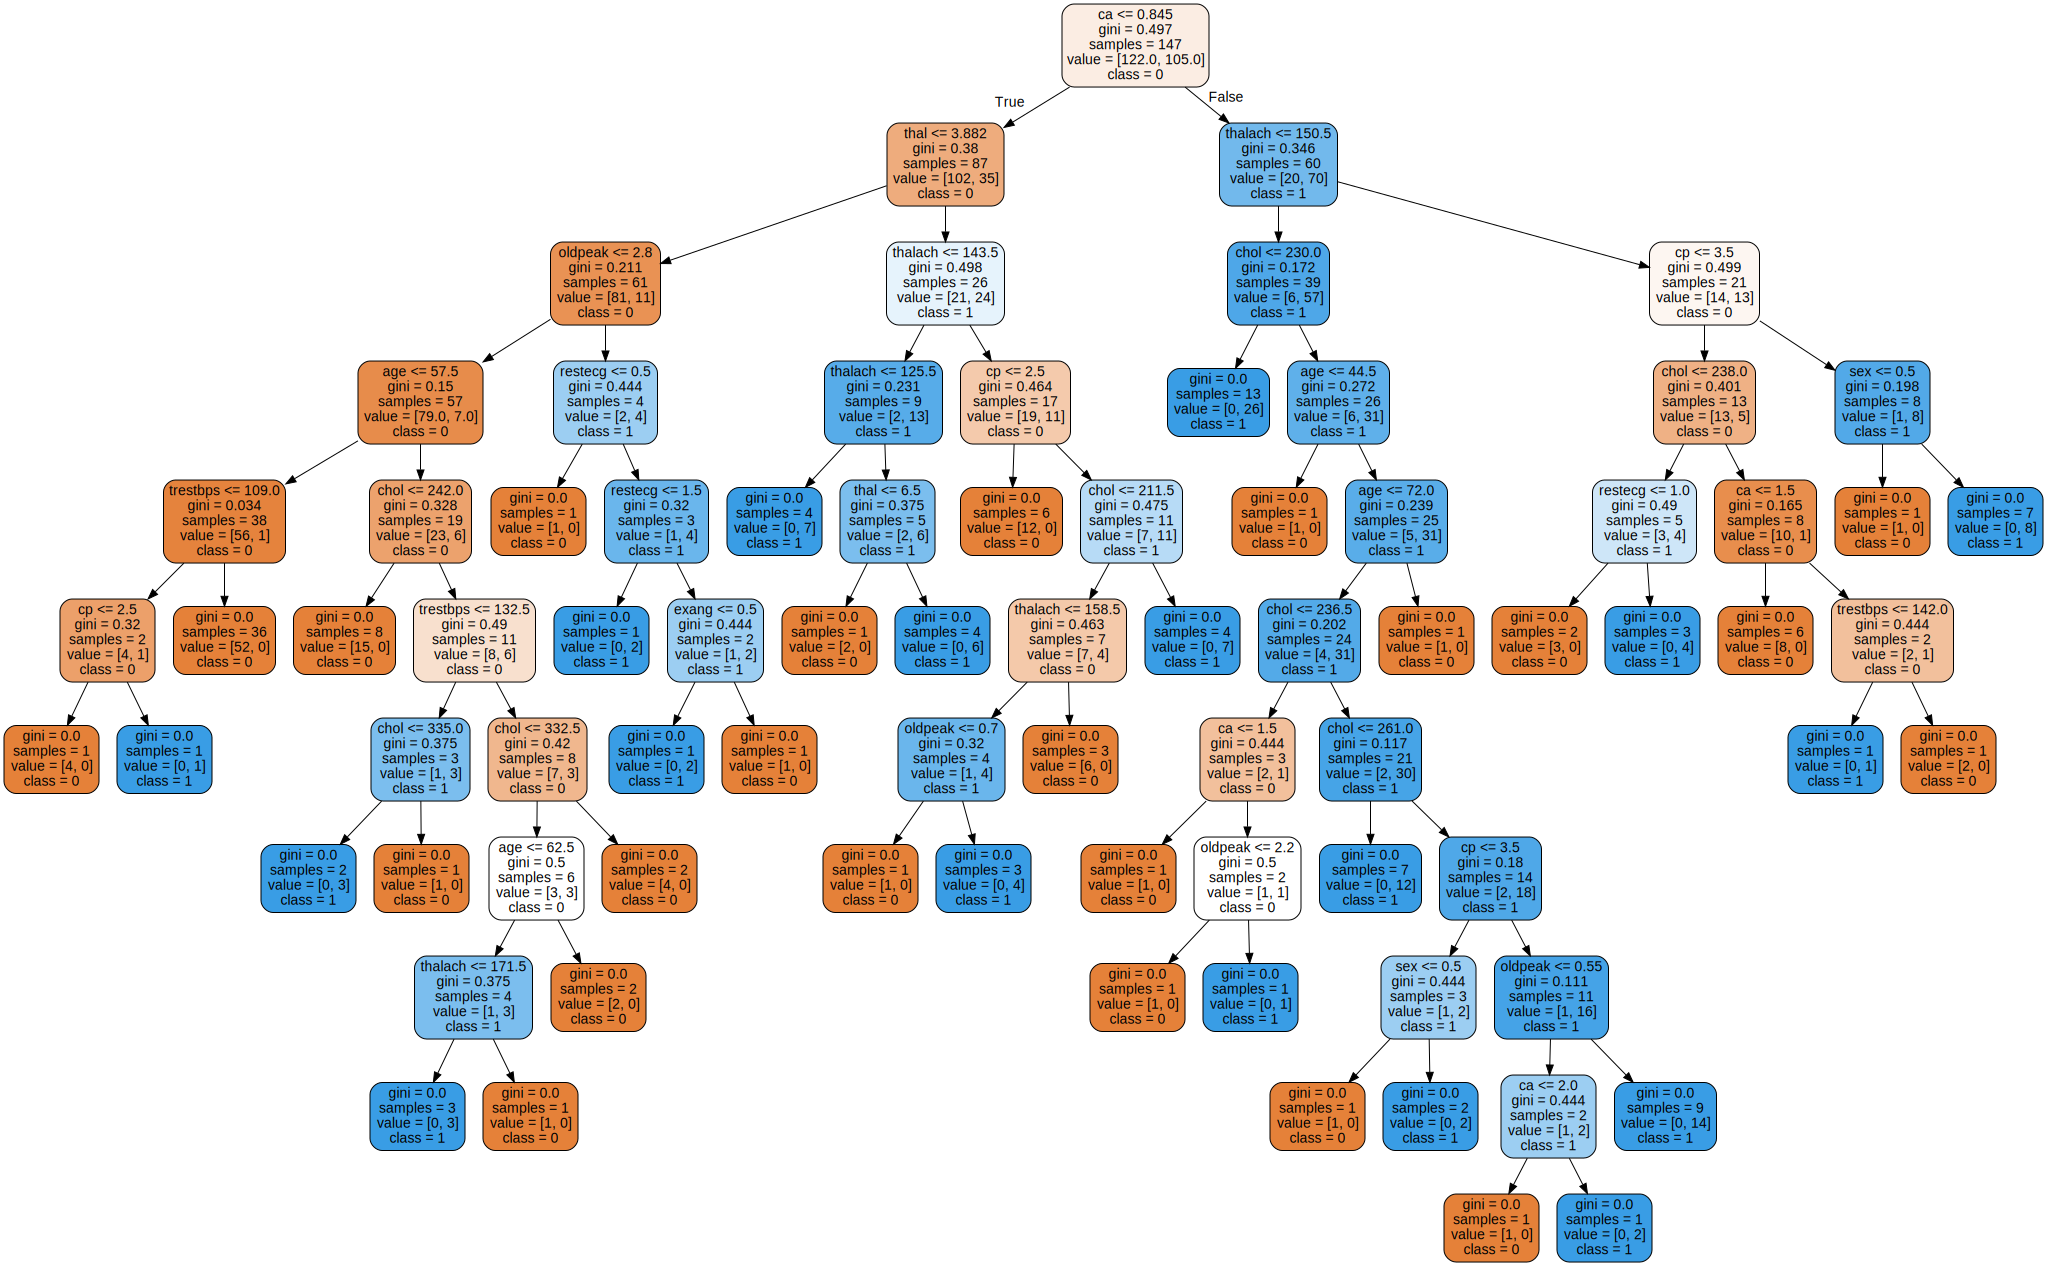

In [8]:
from sklearn.metrics import f1_score, accuracy_score
search_space = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42), {
        'max_depth': [3, 5, 10, None],
        'min_samples_leaf': [1, 2, 5],
        'criterion': ['gini', 'entropy']
    }),
    ('Bagging', BaggingClassifier(DecisionTreeClassifier(), random_state=42), {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.8, 1.0],
        'max_features': [0.5, 0.8, 1.0]
    }),
    ('Random Forest', RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    })
]

best_f1 = 0
best_model = None

for name, model, params in search_space:
    print(f"--- {name} ---")
    grid = GridSearchCV(model, params, cv=5, scoring='f1_macro')
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Best Params: {grid.best_params_}")
    print(f"Accuracy: {acc:.4f}, F1 Macro: {f1:.4f}\n")

    if f1 > best_f1:
        best_f1 = f1
        best_model = grid.best_estimator_

print(f"Best Model is: {best_model}")
if isinstance(best_model, DecisionTreeClassifier):
    tree_to_plot = best_model
else:
    tree_to_plot = best_model.estimators_[0]

export_graphviz(tree_to_plot, out_file="tree.dot", feature_names=data.columns[:-1],
                class_names=['0', '1'], filled=True, rounded=True)
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)